In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
from pathlib import Path

# Step 1. SentencePiece 설치하기
[google/sentencepiece](https://github.com/google/sentencepiece)  
SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer. BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것.  
SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화됨. 최근 pre-trained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할.

In [2]:
# !pip install sentencepiece

# Step 2. SentencePiece 모델 학습
SentencePiece 모델 학습

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


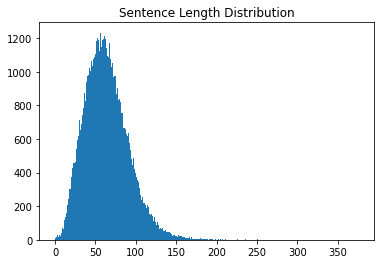

In [4]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

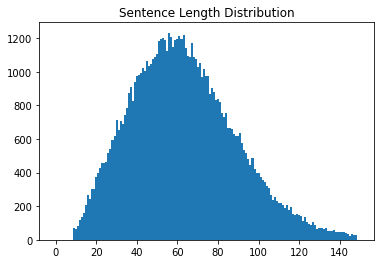

In [5]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [6]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Jul  1 06:13 korean_spm.model
-rw-r--r-- 1 root root 146213 Jul  1 06:13 korean_spm.vocab


In [7]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# Step 3. Tokenizer 함수 작성
위에서 학습시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수 정의.  
SentencePiece가 동작하는 방식이 단순 토큰화와 달라 동일하게 정의하기 어려움.  
sp_tokenize() 조건  
1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 전달
2. 생성된 vocab 파일을 읽어와 { \\<word> : \\<idx> } 형태를 가지는 word_index 사전과 { \\<idx> : \\<word> } 형태를 가지는 index 사전을 생성하고 함께 반환
3. 리턴값인 tensor에 padding 추가

In [8]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [9]:
print(sp_tokenize(s, filtered_corpus[:5]))

(array([[1611,  355,   12, 4917, 2309, 1024, 2424, 4028,   19,   85,  377,
        1953,  145,  211,  412, 4556,   67,   72,    9, 4354,  516,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 644,  436,  555,  180, 2188,  257, 2447,  208,   42,  849,  551,
        3373,  180,  285, 7667,    5,  218,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 702, 1054, 3400, 6268,    6,    4, 7894,  288,   11,  631,   10,
          93,  658,   36,   49,   21,    4, 7894,  288,    9, 3280,   39,
        2540, 1813,    3,    0,    0,    0,    0,    0,    0,    0,    0],
       [1001, 1157,  740,  664,   12, 1300, 3071,  292,    8, 2863,  689,
           7, 3888, 2101,    5, 1131,   13,  774, 4955, 1148, 1888,    5,
         154, 2967,   10, 2439,   11, 2815,  990, 1141,   14,   57,    3],
       [ 342,   18,    8,   84,  624,  350,  190,  211, 1475,  407,    7,
        6635,   91,   14,  336, 2